In [1]:
from utilities import *
from manualspeciesabundances import *
from astropy.table import Table
import sys
import glob
from spectral_cube import SpectralCube as sc
import pdb
import math
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
from pyspeckit.spectrum.models import lte_molecule
from astropy.modeling import models
import matplotlib as mpl
from astroquery.splatalogue import Splatalogue as splat
from astroquery.splatalogue import utils

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [2]:
source='DSi'
molecule=' C2H5OH '
incompleteqrot=[' C2H5OH ']
linelist=linelistdict[molecule]
mastervelocities=masterdopplershifts[molecule]
if source == 'SgrB2S':
    z_sgrb2s=0.0002223
elif source in mastervelocities.keys():
    dopplershift_z=(mastervelocities[source]/(c.to('km s-1'))).to('').value
else:
    dopplershift_z=ch3oh_dopplershifts[source]
dopplershift_kms=dopplershift_z*c.to('km s-1')
truesubplotwidth=10*u.km/u.s

In [3]:
images=['spw0','spw1','spw2','spw3']
print(f'Source: {source}')
fnum=fields[source]
pixcoords=pixdict[source]
minicubedir=minicube_end[fnum]
z=dopplershift_z#ch3oh_dopplershifts[source]

cubelocs=f'/orange/adamginsburg/sgrb2/2017.1.00114.S/desmond/SgrB2DSminicubes/{source}/{minicubedir}*.fits'
cubes=glob.glob(cubelocs)
cubes.sort()

reorgpath=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/'+ch3oh_sourcedict[source]
mastertxttablepath=reorgpath+'mastereuksqnsfreqsdegens.fits'
fwhmpath=glob.glob(reorgpath+'*fwhm*')[0]
nch3ohpath=reorgpath+'bootstrap_ntot_intstd_boostrap1000_nonegativeslope.fits'
picklepath=reorgpath+'ch3ohlinesdict.obj'
trotmappath=reorgpath+'bootstrap_texmap_3sigma_allspw_withnans_weighted.fits'
fluxerrorpath=reorgpath+'errorimgs/std/*.fits'

openfile=open(picklepath,'rb')
pklch3oh=pickle.load(openfile)
sourcefwhm=fits.getdata(fwhmpath)*u.km/u.s
trotmap=fits.getdata(trotmappath)*u.K
measTrot=trotmap[pixcoords[0],pixcoords[1]]
measlinewidth=sourcefwhm[pixcoords[0],pixcoords[1]]
fluxerrorcubes=glob.glob(fluxerrorpath)
fluxerrorcubes.sort()

numdetections=0
datatoplot=[]
modelstoplot=[]
potentialcontaminants=[]

Source: DSi


In [12]:
for path,spwname,stdimage in zip(cubes,images,fluxerrorcubes):
    print(f'Gathering {molecule} lines from {spwname}')
    cube=sc.read(path)
    errormap=fits.getdata(stdimage)
    error=errormap[pixcoords[0],pixcoords[1]]*u.K
    freqs=cube.spectral_axis
    freqmin=freqs.min()
    freqmax=freqs.max()
    
    if linelist=='CDMS':
        if molecule in cdmsnamelist.keys():
            queryname=cdmsnamelist[molecule]
        elif molecule == 'CH3NCO, vb = 0':
            queryname=cdms_get_molecule_name('CH3NCO, vb=0')
        else:
            param_name=molecule.replace(' ','')
            queryname=cdms_get_molecule_name(param_name)#cdmsnamelist[molecule]

        if queryname in cdmsproblemchildren:
            freqs, aij, deg, EU, qrot = get_molecular_parameters(queryname,catalog='CDMS',
                                                                           fmin=freqmin, fmax=(freqmax+100*u.GHz),)
        else:
            freqs, aij, deg, EU, qrot = get_molecular_parameters(queryname,catalog='CDMS',fmin=freqmin,fmax=(freqmax+50*u.GHz))
    if linelist == 'JPL':
        if molecule in jplnamelist.keys():
            queryname=jplnamelist[molecule]
        else:
            queryname=molecule.replace(' ','')
        freqs, aij, deg, EU, qrot = get_molecular_parameters(queryname,catalog='JPL',
                                                     fmin=freqmin,
                                                     fmax=freqmax,)
    species_table= Splatalogue.query_lines(freqmin, freqmax, chemical_name=molecule, energy_max=1840, energy_type='eu_k', line_lists=[linelistdict[molecule]], show_upper_degeneracy=True)
    minimize_table=utils.minimize_table(species_table)
    restfreqs=minimize_table['Freq']*u.GHz
    reffreqs=(restfreqs/(1+z))
    qns=minimize_table['QNs']
    euks=minimize_table['EU_K']*u.K
    log10aijs=minimize_table['log10_Aij']
    aijs=10**log10aijs*u.s**-1
    degs=species_table['Upper State Degeneracy']
    splatfluxes=species_table['CDMS/JPL Intensity']
    if molecule in incompleteqrot:
        print(f'{molecule} has an incomplete partition function')
        print('Estimating by linear fit to log-log Qrot/T relation')
        poly=Linear1D(slope=150, intercept=10)
        fitter=fitting.LinearLSQFitter()
        fitinput_xvalues=np.linspace(3,300,1000)*u.K
        power_law_fit=fitter(poly,np.log10(fitinput_xvalues.value),np.log10(qrot(fitinput_xvalues)))
        logintercept=10**power_law_fit.intercept
        logTs=logintercept*fitinput_xvalues.value**power_law_fit.slope

        def fit_qrot(input_temperature=301*u.K):
            return logintercept*input_temperature.value**power_law_fit.slope
        '''
        plt.plot(fitinput_xvalues,logTs)
        plt.scatter(fitinput_xvalues,qrot(fitinput_xvalues),s=7,color='orange')
        #plt.plot(fitinput_xvalues,(2*fitinput_xvalues+10),color='green')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        sys.exit()
        '''
    measQrot=fit_qrot(measTrot)
    for reffreq,restline,linedeg,lineeuk,lineaij,lineqn,splatflux in zip(reffreqs,restfreqs,deg,euks,aijs,qns,splatfluxes):
        labelqn=lineqn#str(round(line.value,2))
        if reffreq >= freqmin and reffreq <= freqmax:
            if source == 'SgrB2S':
                if molecule ==' C2H5OH ':
                    eukcutoff=1000*u.K
                    intensitycut=-9
                    if splatflux <= intensitycut or lineeuk >= eukcutoff:
                        continue
                restline=reffreq*(1+z)
                reffreq=restline/(1+z_sgrb2s)
                #print('Collecting measured spectra from spectral slab')
                subplotwidth=velocitytofreq(truesubplotwidth,reffreq)
                lineslab=cube.spectral_slab((reffreq-subplotwidth),(reffreq+subplotwidth))
                #vel_lineslab=lineslab.with_spectral_unit('km s-1',velocity_convention='radio',rest_value=reffreq)
                lineflux=lineslab[:,pixcoords[0],pixcoords[1]]
                linespecax=lineslab.spectral_axis
                vel_linespecax=lineslab.with_spectral_unit('km s-1',velocity_convention='radio',rest_value=reffreq).spectral_axis#freqtovelocity(linespecax,reffreq)

                #print('Collecting values for line model')
                modlinewidth=velocitytofreq(measlinewidth,reffreq)
                lineprofilesigma=modlinewidth/(2*np.sqrt(2*np.log(2)))
                vel_lineprofilesigma=measlinewidth/(2*np.sqrt(2*np.log(2)))
                phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
                molntot=sourcecolumns[source][molecule]
                linedeg=line['Degeneracy']
                lineeuk=line['EuK']*u.K
                lineeuj=(lineeuk*k).to('J')
                lineaij=pklch3oh[spwname][tempstr]['aij']
                
                #print('Calculate line model')
                modnupper=nupper_estimated(molntot,linedeg,measQrot,lineeuj,measTrot).to('cm-2')
                intertau=lte_molecule.line_tau(measTrot, molntot, measQrot, linedeg, restline, lineeuj, lineaij)
                est_tau=(intertau*phi_nu).to('')
                trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=measTrot).to('K')
                if trad <= 3*error or np.isnan(trad.value):
                    continue
                else:
                    modelline=models.Gaussian1D(mean=(0*u.km/u.s), stddev=vel_lineprofilesigma, amplitude=trad)
                    modelstoplot.append([labelqn,modelline])
                    datatoplot.append([labelqn,vel_linespecax,lineflux,reffreq])
                
            else:
                #Collecting measured spectra from spectral slab
                subplotwidth=velocitytofreq(truesubplotwidth,reffreq)
                lineslab=cube.spectral_slab((reffreq-subplotwidth),(reffreq+subplotwidth))
                #vel_lineslab=lineslab.with_spectral_unit('km s-1',velocity_convention='radio',rest_value=reffreq)
                lineflux=lineslab[:,pixcoords[0],pixcoords[1]]
                linespecax=lineslab.spectral_axis
                vel_linespecax=lineslab.with_spectral_unit('km s-1',velocity_convention='radio',rest_value=reffreq).spectral_axis#freqtovelocity(linespecax,reffreq)
                #datatoplot.append([labelqn,vel_linespecax,lineflux,reffreq])
    
                #Collecting values for line model
                restline=reffreq*(1+z)
                modlinewidth=velocitytofreq(measlinewidth,reffreq)
                lineprofilesigma=modlinewidth/(2*np.sqrt(2*np.log(2)))
                vel_lineprofilesigma=measlinewidth/(2*np.sqrt(2*np.log(2)))
                phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
                molntot=sourcecolumns[source][molecule]
                #linedeg=line['Degeneracy']
                #lineeuk=(lineeuj/k).to('K')
                lineeuj=(lineeuk*k).to('J')
                #lineaij=pklch3oh[spwname][tempstr]['aij']
    
                #Calculate line model
                modnupper=nupper_estimated(molntot,linedeg,measQrot,lineeuj,measTrot).to('cm-2')
                intertau=lte_molecule.line_tau(measTrot, molntot, measQrot, linedeg, restline, lineeuj, lineaij)
                est_tau=(intertau*phi_nu).to('')
                trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=measTrot).to('K')
                if trad < 3*error or np.isnan(trad.value):
                    #print('Ping')
                    #sys.exit()
                    continue
                else:
                    #if lineqn == '8(4,4)-7(3,4),g+':
                    #    sys.exit()
                    modelline=models.Gaussian1D(mean=(0*u.km/u.s), stddev=vel_lineprofilesigma, amplitude=trad)
                    #Apply chi-squared test to line
                    velocityrange_chisquared=np.linspace(-(measlinewidth/2),(measlinewidth/2),10)
                    chisquared=np.sum((lineflux[10:20]-modelline(velocityrange_chisquared))**2/(error*np.ones(10))).value/len(lineflux)
                    degrees_of_freedom=len(lineflux)-2#we would be fitting Trot and Ntot
                    goodness_of_fit=np.abs(np.sqrt(2*chisquared)-np.sqrt(2*degrees_of_freedom-1))
                    print(f'\n{lineqn} chi-squared: {chisquared}')
                    print(f'{lineqn} goodness of fit: {goodness_of_fit}')
                    if goodness_of_fit >= 3:
                        potentialcontaminants.append(lineqn)
                        print(f'Potential contaminant present over {lineqn} @ {reffreq}')
                    else:
                        modelstoplot.append([labelqn,modelline])
                        datatoplot.append([labelqn,vel_linespecax,lineflux,reffreq,lineeuk])
                        numdetections+=1
                    #print('Sing')
                    #sys.exit()
#sys.exit()


Gathering  C2H5OH  lines from spw0
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation

8(4,4)-7(3,4),g+ chi-squared: 2.8000108748285992
8(4,4)-7(3,4),g+ goodness of fit: 5.0497619784064485
Potential contaminant present over 8(4,4)-7(3,4),g+ @ 216.4817587702789 GHz

8(4,5)-7(3,5),g+ chi-squared: 3.8202914688659257
8(4,5)-7(3,5),g+ goodness of fit: 4.785673995330287
Potential contaminant present over 8(4,5)-7(3,5),g+ @ 216.61972572076488 GHz

13(0,13)-12(1,12),g- chi-squared: 28.833826946197902
13(0,13)-12(1,12),g- goodness of fit: 0.044087732647209776

13(1,13)-12(0,12),g- chi-squared: 18.542851955031374
13(1,13)-12(0,12),g- goodness of fit: 1.3263952135848722

5(1,4)-4(0,4),g- chi-squared: 18.823582892952146
5(1,4)-4(0,4),g- goodness of fit: 1.4141058081308326

25(3,22)-24(4,20),g+ chi-squared: 3.2789558544368047
25(3,22)-24(4,20),g+ goodness of fit: 4.855356494923242
Potential contaminant present over 25(3,22)-24(4,20),g+ @ 217.5092061463

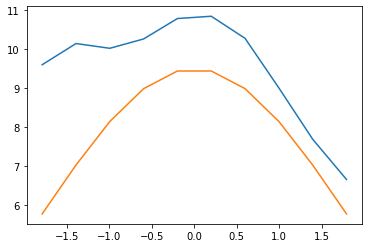

In [42]:
plt.plot(velocityrange_chisquared,lineflux.value[10:20])
plt.plot(velocityrange_chisquared,modelline(velocityrange_chisquared))

In [9]:
lineflux[10:20]

<VaryingResolutionOneDSpectrum [ 0.766901 , 3.4767308, 6.812543 ,
                                 9.625846 ,11.639635 ,13.986965 ,
                                17.725136 ,21.373215 ,22.608011 ,
                                24.718878 ] K>

In [10]:
modelline(velocityrange_chisquared)

<Quantity [16.19127653, 19.72730025, 22.87744805, 25.25229534, 26.53062622,
           26.53062622, 25.25229534, 22.87744805, 19.72730025, 16.19127653] K>

In [11]:
velocityrange_chisquared

<Quantity [-1.79105259, -1.3930409 , -0.99502921, -0.59701753, -0.19900584,
            0.19900584,  0.59701753,  0.99502921,  1.3930409 ,  1.79105259] km / s>